<h1> Create Keras DNN model </h1>

This notebook illustrates:
<ol>
<li> Creating a model using Keras. This requires TensorFlow 2.0
</ol>

In [7]:
# change these to try this notebook out
BUCKET = 'cloud-training-demos-ml'
PROJECT = 'cloud-training-demos'
REGION = 'us-central1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

In [4]:
%%bash
ls *.csv

eval.csv
train.csv


## Create Keras model
<p>
First, write an input_fn to read the data.

In [5]:
import shutil
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190908


In [10]:
# Determine CSV, label, and key columns
CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks,key'.split(',')
LABEL_COLUMN = 'weight_pounds'
KEY_COLUMN = 'key'

# Set default values for each CSV column. Treat is_male and plurality as strings.
DEFAULTS = [[0.0], ['null'], [0.0], ['null'], [0.0], ['nokey']]

In [9]:
def features_and_labels(row_data):
    for unwanted_col in ['key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

Next, define the feature columns. mother_age and gestation_weeks should be numeric.
The others (is_male, plurality) should be categorical.

In [11]:
## Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

# Helper function to handle categorical columns
def categorical_fc(name, values):
  return tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(name, values))

def build_dnn_model():
    # input layer
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in ['mother_age', 'gestation_weeks']
    }
    inputs.update({
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string')
           for colname in ['is_male', 'plurality']        
    })
    
    # feature columns from inputs
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
           for colname in ['mother_age', 'gestation_weeks']
    }
    feature_columns['is_male'] = categorical_fc('is_male', ['True', 'False', 'Unknown'])
    feature_columns['plurality'] = categorical_fc('plurality',
                      ['Single(1)', 'Twins(2)', 'Triplets(3)',
                       'Quadruplets(4)', 'Quintuplets(5)','Multiple(2+)'])

    # the constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [64, 32] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(64, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(32, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='weight')(h2)
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

W0923 05:29:05.136780 139961458415360 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4281: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0923 05:29:05.138256 139961458415360 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4336: VocabularyListCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Here is our DNN architecture so far:

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gestation_weeks (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
is_male (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
mother_age (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
plurality (InputLayer)          [(None,)]            0                                            
________________________________________________________

We can visualize the DNN using the Keras plot_model utility.

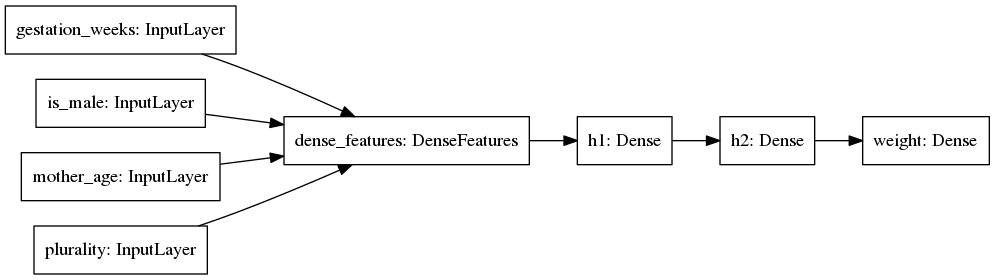

In [13]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Train and evaluate

In [14]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('eval*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

W0923 05:31:24.649794 139961458415360 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/data/experimental/ops/readers.py:540: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
W0923 05:31:24.678033 139961458415360 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/data/experimental/ops/readers.py:214: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizati

Train for 312 steps, validate for 10 steps
Epoch 1/5
312/312 [==============================] - 3s 10ms/step - loss: 3.5295 - rmse: 1.4214 - mse: 3.5295 - val_loss: 1.2318 - val_rmse: 1.1098 - val_mse: 1.2318
Epoch 2/5
312/312 [==============================] - 1s 4ms/step - loss: 1.2208 - rmse: 1.0924 - mse: 1.2208 - val_loss: 1.2047 - val_rmse: 1.0975 - val_mse: 1.2047
Epoch 3/5
312/312 [==============================] - 1s 4ms/step - loss: 1.2742 - rmse: 1.1136 - mse: 1.2742 - val_loss: 1.1989 - val_rmse: 1.0949 - val_mse: 1.1989
Epoch 4/5
312/312 [==============================] - 1s 4ms/step - loss: 1.2282 - rmse: 1.0947 - mse: 1.2282 - val_loss: 1.1756 - val_rmse: 1.0842 - val_mse: 1.1756
Epoch 5/5
312/312 [==============================] - 1s 4ms/step - loss: 1.1701 - rmse: 1.0710 - mse: 1.1701 - val_loss: 1.1662 - val_rmse: 1.0799 - val_mse: 1.1662


## Visualize loss curve

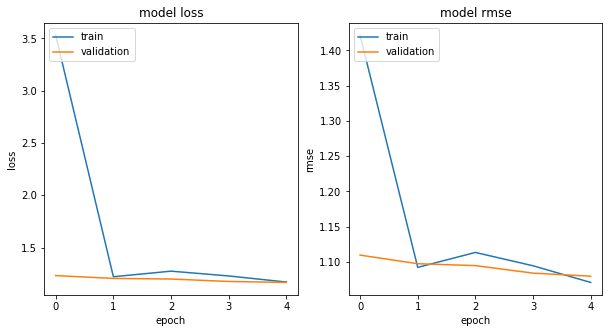

In [15]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Save the model

In [16]:
import shutil, os, datetime
OUTPUT_DIR = 'babyweight_trained'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
tf.saved_model.save(model, EXPORT_PATH) # with default serving function

W0923 05:34:41.533474 139961458415360 deprecation.py:506] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1782: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


<h2> Monitor and experiment with training </h2>

To begin TensorBoard from within AI Platform Notebooks, click the + symbol in the top left corner and select the **Tensorboard** icon to create a new TensorBoard.

In TensorBoard, look at the learned embeddings. Are they getting clustered? How about the weights for the hidden layers? What if you run this longer? What happens if you change the batchsize?

Copyright 2017-2018 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License